<a href="https://colab.research.google.com/github/KennedyPutraKusumo/pydex/blob/master/examples%5Cpydex_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Setting
Consider a steady-state system with 2 control variables and 1 response. An order 1 polynomial response surface model is to be developed for the system. You are tasked with designing the experiments for calibrating the model. Use principles of optimal experiment design to design maximally informative experiments. Since the exact number of experiments to be ran is not specified, it is desirable to design an approximate experiment design.

# Step 1: import packages
The first step is to import the required packages. This comprises of pydex's designer class, and numpy.

In [0]:
from pydex.core.designer import Designer
import numpy as np

# Step 2: specify the model as a simulate function
The model is specified as a Python function with a specific signature that needs to be followed strictly (order matters). Here, because our system is a steady-state system with only one response. The simulate function must return a numpy array, which in this case happens to contain a single element. In cases where we have $n_r$ number of responses and a dynamic system with $N_{\textrm{spt}}$ number of sampling times, the function must return a numpy array with shape $N_{\textrm{spt}} \times n_{r}$.

For now, note that even though the system is steady-state, the simulate signature still requires tv_controls, and sampling times to be passed in.

In [0]:
def simulate(ti_controls, tv_controls, model_parameters, sampling_times):
    return np.array([
        # constant term
        model_parameters[0] +
        # linear term
        model_parameters[1] * ti_controls[0]                    +
        model_parameters[2] * ti_controls[1]                    +
        # interaction term
        model_parameters[3] * ti_controls[0] * ti_controls[1]
    ])

# Step 3: instantiate a designer and declare the simulate function
Once a designer is instantiated, it has a pre-defined method called simulate that is meant to be overwritten. If this pre-defined method is not overwritten, pydex will raise a SyntaxError exception during initialization.

In [0]:
designer_1 = Designer()
designer_1.simulate = simulate

# Step 4: specify nominal model parameter values
The response surface model for this example is a linear model (with respect to its model parameters). This means that the optimal design for the model is independent of the model parameter values. But, at the moment, pydex still requires nominal model parameter values to be passed to the designer. You can pick any value, and it will not affect the result. For this example, we choose a value of 1 for all four model parameters.

The syntax is again similar with specifying the simulate function. When instantiated, a designer will come with a pre-defined attribute named "model_parameters" that needs to be overwritten. We overwrite this with a 1D numpy array with all elements equal to one.

In [0]:
designer_1.model_parameters = np.ones(4)

# Step 5: pass in experimental candidates to optimize over
This step is specific to the discrete approach to optimal experiment design. And before proceeding, it is important to note that it is customary in optimal experiment design to normalize the experimental controls so they take values between -1 and 1.

For this example, since we have two experimental controls, we will need to generate a 2D numpy array with shapes $N_c \times 2$; where $N_c$ is the total number of experimental candidates. For simplicity, we will pass in candidates from a 2D mesh-centered grid with 11 levels in each dimension. This leads to a total of $11^2$ number of experimental candidates. To generate the required 2D numpy array, we will use the numpy function mgrid (a shortcut for np.meshgrid).



In [0]:
tic_1, tic_2 = np.mgrid[-1:1:11j, -1:1:11j]  # tic stands for time-invariant control

A minor note: the complex integer "11j" tells np.mgrid to generate a grid with 11 levels i.e., it tells np.mgrid the number of steps. If a real integer was used (i.e. 11), np.mgrid will instead interpret the argument as the step lengths.

Flattening, collecting, and transposing the returned arrays to get the required 2D numpy array in the right shape.

In [0]:
tic_1 = tic_1.flatten() 
tic_2 = tic_2.flatten()
designer_1.ti_controls_candidates = np.array([tic_1, tic_2]).T

# Step 6: initialize the designer
Before the designer can be used to conduct any activity, it needs to be initialized. During initialization, the designer is going to do two things. First, check if there are any syntax errors made so far. Second, run a single simulation (using the first experimental candidate) to determine the number of responses (as defined in the simulate function).

Here, we also have a choice to determine how verbal we want the designer to be as it conducts experiment design, or any other activity. This is done by setting the verbose value. Note: although not a must, verbose is recommended to be a positive integer. 0: silent, 1: overview, 2: detailed, 3: very detailed

In [0]:
designer_1.initialize(verbose=2)

Running one simulation for initialization (required to determine number of responses).
Initialization complete: designer ready.


'ready'

# Step 7: design experiment

In [0]:
result = designer_1.design_experiment(designer_1.d_opt_criterion, write=False, optimizer="SCS")

Solving OED problem...
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 3110
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 181, constraints m = 238
Cones:	primal zero / dual free vars: 59
	linear vars: 121
	sd vars: 46, sd blks: 2
	exp vars: 12, dual exp vars: 0
Setup time: 6.94e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.74e+19  1.41e+20  1.00e+00 -1.01e+20  2.09e+20  2.14e+20  8.39e-03 
    80| 1.18e-07  7.78e-07  3.94e-07  7.58e-07  1.15e-06  8.77e-17  2.82e-02 
-----------

# Step 8: view results



-------------------------------------------[Candidate 1]--------------------------------------------
                                Recommended Effort: 25.00% of budget                                
Time-invariant Controls:
[-1. -1.]
-------------------------------------------[Candidate 11]-------------------------------------------
                                Recommended Effort: 25.00% of budget                                
Time-invariant Controls:
[-1.  1.]
------------------------------------------[Candidate 111]-------------------------------------------
                                Recommended Effort: 25.00% of budget                                
Time-invariant Controls:
[ 1. -1.]
------------------------------------------[Candidate 121]-------------------------------------------
                                Recommended Effort: 25.00% of budget                                
Time-invariant Controls:
[1. 1.]
######################################################

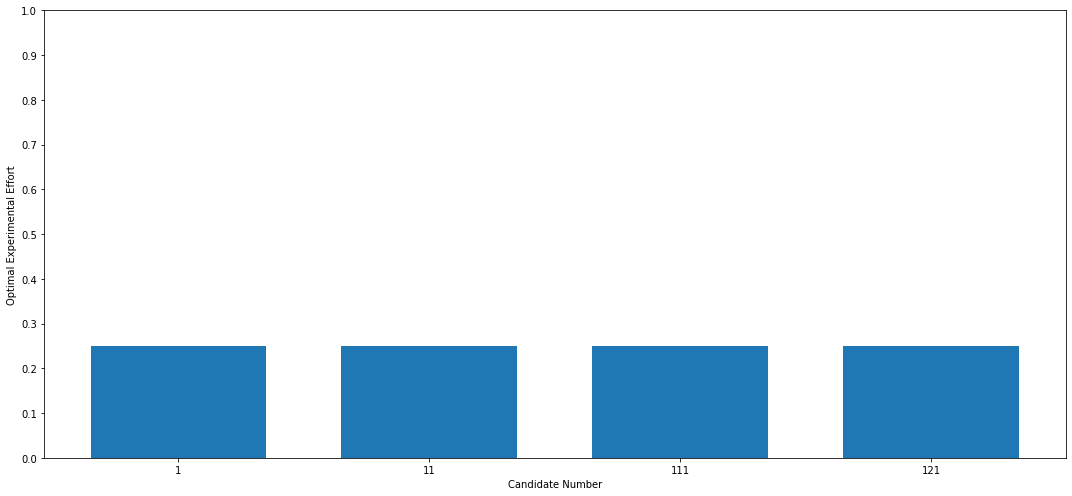

In [0]:
designer_1.print_optimal_candidates()
designer_1.plot_current_design()


For this specific example, we expect a standard factorial design. This means that we may want to view the results manually. Here, we present the design in the most familiar way to confirm that the design really is a factorial design.

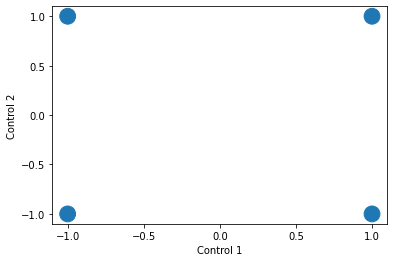

In [0]:
from matplotlib import pyplot as plt

fig1 = plt.figure()
axes1 = fig1.add_subplot(111)
axes1.scatter(designer_1.ti_controls_candidates[:, 0], designer_1.ti_controls_candidates[:, 1],
              s=np.round(designer_1.efforts*1000, decimals=2))
axes1.set_xlabel("Control 1")
axes1.set_ylabel("Control 2")
axes1.set_xticks([-1, -.5, 0, .5, 1])
axes1.set_yticks([-1, -.5, 0, .5, 1])
plt.show()